In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os, re
import cv2
import glob
import pathlib
import time
import datetime
from IPython import display
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. VGG_Ablation_Study

## (1) CIFAR-10 데이터셋 준비

### 1) CIFAR-10

In [2]:
# Tensorflow가 활용할 GPU의 장착 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                        shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### 2) Input Normalization

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

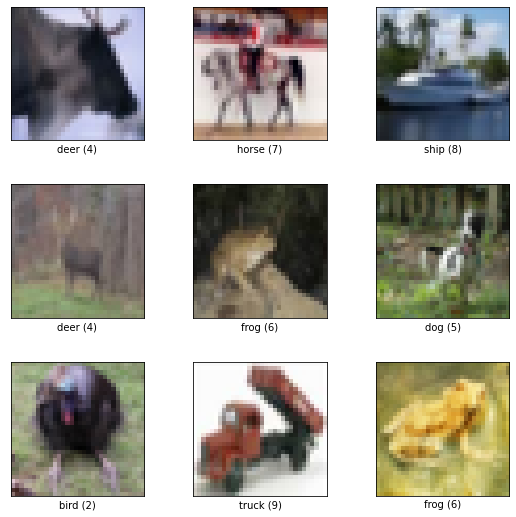

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

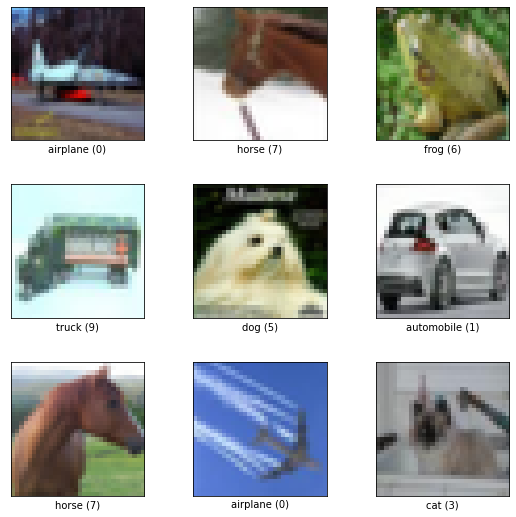

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## (2) VGG 기본 블록 만들기

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,num_cnn=3, channel=64, block_num=1):
    
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), activation='relu',
            kernel_initializer='he_normal', padding='same', name=f'block{block_num}_conv{cnn_num}')(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name=f'block{block_num}_pooling')(x)

    return x

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))  # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## (3) VGG Complete Model

### 1) VGG Model 생성

In [15]:
# VGG 모델 자체를 생성하는 함수
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만듦
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(output, num_cnn=num_cnn, channel=channel, block_num=i)
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

### 2) VGG-16

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됨
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 3) VGG-19

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512],
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## (4) Ablation Study 실습 

### 1) VGG-16

In [18]:
BATCH_SIZE = 256
EPOCH = 40

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [20]:
vgg_16.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.), metrics=['accuracy'])

history_16 = vgg_16.fit(ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/40
195/195 [==============================] - 37s 124ms/step - loss: 2.2251 - accuracy: 0.1715 - val_loss: 2.1084 - val_accuracy: 0.1942
Epoch 2/40
195/195 [==============================] - 23s 120ms/step - loss: 2.0265 - accuracy: 0.2598 - val_loss: 1.9273 - val_accuracy: 0.2990
Epoch 3/40
195/195 [==============================] - 25s 129ms/step - loss: 1.8986 - accuracy: 0.3128 - val_loss: 1.8118 - val_accuracy: 0.3532
Epoch 4/40
195/195 [==============================] - 24s 123ms/step - loss: 1.7894 - accuracy: 0.3564 - val_loss: 1.6906 - val_accuracy: 0.3952
Epoch 5/40
195/195 [==============================] - 24s 124ms/step - loss: 1.6969 - accuracy: 0.3857 - val_loss: 1.6433 - val_accuracy: 0.4022
Epoch 6/40
195/195 [==============================] - 24s 123ms/step - loss: 1.6355 - accuracy: 0.4048 - val_loss: 1.6113 - val_accuracy: 0.4252
Epoch 7/40
195/195 [==============================] - 24s 123ms/step - loss: 1.5760 - accuracy: 0.4332 - val_loss: 1.5086 - val_ac

### 2) VGG-19

In [21]:
vgg_19.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),metrics=['accuracy'])

history_19 = vgg_19.fit(ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/40
195/195 [==============================] - 34s 145ms/step - loss: 2.2512 - accuracy: 0.1550 - val_loss: 2.1306 - val_accuracy: 0.2074
Epoch 2/40
195/195 [==============================] - 28s 145ms/step - loss: 2.0724 - accuracy: 0.2418 - val_loss: 1.9815 - val_accuracy: 0.2898
Epoch 3/40
195/195 [==============================] - 28s 143ms/step - loss: 1.9146 - accuracy: 0.3047 - val_loss: 1.8329 - val_accuracy: 0.3471
Epoch 4/40
195/195 [==============================] - 28s 144ms/step - loss: 1.7875 - accuracy: 0.3482 - val_loss: 1.7497 - val_accuracy: 0.3578
Epoch 5/40
195/195 [==============================] - 28s 145ms/step - loss: 1.6892 - accuracy: 0.3860 - val_loss: 1.6346 - val_accuracy: 0.4024
Epoch 6/40
195/195 [==============================] - 28s 144ms/step - loss: 1.6214 - accuracy: 0.4125 - val_loss: 1.5743 - val_accuracy: 0.4264
Epoch 7/40
195/195 [==============================] - 28s 144ms/step - loss: 1.5592 - accuracy: 0.4333 - val_loss: 1.5620 - val_ac

### 3) VGG-16 vs. VGG-19 그래프 비교

#### Training Loss

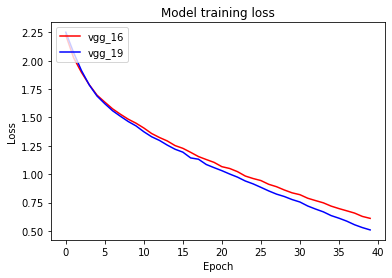

In [22]:
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

#### Validation Accuracy

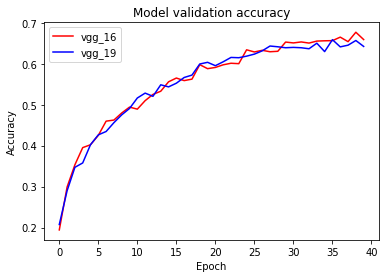

In [23]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# 2. Project_ResNet_Ablation_Study

## (1) ResNet 기본 블록 만들기

In [24]:
# function for building ResNet Block

def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1, first_block=False):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        if cnn_num == 0:
            if first_block:
                stride = 1
            else:
                stride = 2
            shortcut = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), strides=stride,
                kernel_initializer='he_normal', padding='same', name=f'block{block_num}_shortcut')(x)
            shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_bn_shortcut')(shortcut)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=stride, activation='relu',
            kernel_initializer='he_normal', padding='same', name=f'block{block_num}_conv{cnn_num}')(x)    
        x = keras.layers.BatchNormalization(name=f'block{block_num}_bn{cnn_num}')(x)
        x = keras.layers.Activation('relu', name=f'block{block_num}_relu{cnn_num}')(x)

    # identity connection
    if first_block:
        x = keras.layers.add([x, shortcut], name=f'block{block_num}_add')
    
    return x

In [25]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))  # 입력 레이어 생성
resnet_block_output = build_resnet_block(resnet_input_layer)

In [26]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 64)        1792      
_________________________________________________________________
block1_bn0 (BatchNormalizati (None, 16, 16, 64)        256       
_________________________________________________________________
block1_relu0 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 8, 8, 64)          36928     
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 8, 8, 64)          256       
_________________________________________________________________
block1_relu1 (Activation)    (None, 8, 8, 64)          0   

## (2) ResNet Complete Model

### 1) ResNet Model 생성

In [27]:
def build_resnet(input_shape, num_blocks=[3, 4, 6, 3], num_classes=2):
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # Conv2D
    x = keras.layers.Conv2D(64, (7,7), strides=2, padding='same', name='conv1')(input_layer)
    x = keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = keras.layers.Activation('relu')(x)
    
    # MaxPooling2D
    x = keras.layers.MaxPooling2D((3,3), strides=2, padding='same', name='max_pool')(x)
    
    # ResNet Block x3 (64, [64, 64, 256]) 
    x = build_resnet_block(x, num_cnn=3, channel=64, block_num=2, first_block=True)
    for i in range(num_blocks[0]-1):
        x = build_resnet_block(x, num_cnn=3, channel=64, block_num=i+3, first_block=False)
    
    # ResNet Block x4 (128, [128, 128, 512]) 
    x = build_resnet_block(x, num_cnn=3, channel=128, block_num=6, first_block=True)
    for i in range(num_blocks[1]-1):
        x = build_resnet_block(x, num_cnn=3, channel=128, block_num=i+7, first_block=False)
    
    # ResNet Block x6 (256, [256, 256, 1024]) 
    x = build_resnet_block(x, num_cnn=3, channel=256, block_num=12, first_block=True)
    for i in range(num_blocks[2]-1):
        x = build_resnet_block(x, num_cnn=3, channel=256, block_num=i+13, first_block=False)
    
    # ResNet Block x3 (512, [512, 512, 2048]) 
    x = build_resnet_block(x, num_cnn=3, channel=512, block_num=24, first_block=True)
    for i in range(num_blocks[3]-1):
        x = build_resnet_block(x, num_cnn=3, channel=512, block_num=i+25, first_block=False)
    
    # AveragePooling2D
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Dense
    x = keras.layers.Dense(num_classes, activation='softmax', name='fc')(x)
    
    # model 생성
    model = keras.models.Model(inputs=input_layer, outputs=x)
    
    return model

### 2) ResNet-34

In [28]:
resnet34 = build_resnet(input_shape=(32, 32, 3), num_blocks=[3, 4, 6, 3], num_classes=2)
resnet34.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_5[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           bn_conv1[0][0]                   
____________________________________________________________________________________________

### 3) ResNet-50

In [29]:
resnet50 = build_resnet(input_shape=(32, 32, 3), num_blocks=[3, 4, 6, 3], num_classes=2)
resnet50.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           bn_conv1[0][0]                   
____________________________________________________________________________________________

## (3) Ablation Study 실습

### 1) 일반 네트워크(plain network) 만들기

ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요함

#### 블록 코드 수정

In [30]:
def build_plain_block(input_layer, num_cnn=3, channel=64, block_num=1):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), activation='relu',
            kernel_initializer='he_normal', padding='same', name=f'block{block_num}_conv{cnn_num}')(x)    
        x = keras.layers.BatchNormalization(name=f'block{block_num}_bn{cnn_num}')(x)
        x = keras.layers.Activation('relu', name=f'block{block_num}_relu{cnn_num}')(x)
    
    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name=f'block{block_num}_pooling')(x)
    
    return x

In [31]:
plain_input_layer = keras.layers.Input(shape=(32,32,3))  # 입력 레이어 생성
plain_block_output = build_plain_block(plain_input_layer, num_cnn=3, channel=64, block_num=1)

In [32]:
# 블록 1개짜리 plain net model 생성
model = keras.Model(inputs=plain_input_layer, outputs=plain_block_output)  

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_bn0 (BatchNormalizati (None, 32, 32, 64)        256       
_________________________________________________________________
block1_relu0 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 32, 32, 64)        256       
_________________________________________________________________
block1_relu1 (Activation)    (None, 32, 32, 64)        0   

#### 전체 함수 코드 수정

In [33]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model


def build_plainnet(num_layers, num_classes, input_shape=(32, 32, 3)):
    # Define input layer
    input_layer = Input(shape=input_shape)
    
    # Define number of filters for each block
    if num_layers == 34:
        filters = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
    elif num_layers == 50:
        filters = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 1024, 1024, 1024, 2048, 2048, 2048]
    else:
        raise ValueError("PlainNet-{} is not supported.".format(num_layers))
    
    # Define convolutional blocks
    x = input_layer
    for i in range(len(filters)-1):
        x = Conv2D(filters[i], kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i in [1, 4, 7, 10]:
            x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Define last convolutional block
    x = Conv2D(filters[-1], kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Define output layer
    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # Define model
    model = Model(input_layer, output_layer)
    
    return model

In [40]:
# PlainNet-34 생성
plainnet34 = build_plainnet(input_shape=(32, 32, 3), num_layers=34, num_classes=2)

In [41]:
# PlainNet-50 생성
plainnet50 = build_plainnet(input_shape=(32, 32, 3), num_layers=50, num_classes=2)

### 2) Ablation Study (ResNet-50 vs. Plain-50)

#### [ResNet-50]

In [36]:
BATCH_SIZE = 256
EPOCHS = 40

In [37]:
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                         as_supervised=True, shuffle_files=True, with_info=True)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [38]:
resnet50.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.), metrics=['accuracy'])

history_resnet50 = resnet50.fit(ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/40
195/195 [==============================] - 39s 126ms/step - loss: nan - accuracy: 0.1019 - val_loss: nan - val_accuracy: 0.0982
Epoch 2/40
195/195 [==============================] - 24s 124ms/step - loss: nan - accuracy: 0.1006 - val_loss: nan - val_accuracy: 0.1024
Epoch 3/40
195/195 [==============================] - 23s 119ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.1008
Epoch 4/40
195/195 [==============================] - 23s 119ms/step - loss: nan - accuracy: 0.1007 - val_loss: nan - val_accuracy: 0.1007
Epoch 5/40
195/195 [==============================] - 23s 119ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.1014
Epoch 6/40
195/195 [==============================] - 23s 119ms/step - loss: nan - accuracy: 0.1011 - val_loss: nan - val_accuracy: 0.0982
Epoch 7/40
195/195 [==============================] - 23s 119ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0968
Epoch 8/40
195/195 [=======

#### [Plain-50]

In [42]:
plainnet50.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.), metrics=['accuracy'])

history_plainnet50 = plainnet50.fit(ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/40
195/195 [==============================] - 105s 458ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.1009
Epoch 2/40
195/195 [==============================] - 87s 444ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.1016
Epoch 3/40
195/195 [==============================] - 86s 440ms/step - loss: nan - accuracy: 0.1015 - val_loss: nan - val_accuracy: 0.1022
Epoch 4/40
195/195 [==============================] - 86s 441ms/step - loss: nan - accuracy: 0.0989 - val_loss: nan - val_accuracy: 0.0954
Epoch 5/40
195/195 [==============================] - 86s 440ms/step - loss: nan - accuracy: 0.1019 - val_loss: nan - val_accuracy: 0.1012
Epoch 6/40
195/195 [==============================] - 86s 441ms/step - loss: nan - accuracy: 0.0980 - val_loss: nan - val_accuracy: 0.1015
Epoch 7/40
195/195 [==============================] - 86s 441ms/step - loss: nan - accuracy: 0.0994 - val_loss: nan - val_accuracy: 0.0973
Epoch 8/40
195/195 [======

#### [ResNet-50 vs. Plain-50 그래프 비교]

##### - Validation Accuracy

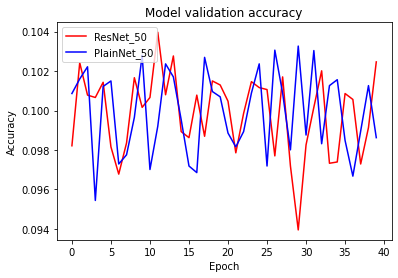

In [44]:
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plainnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_50', 'PlainNet_50'], loc='upper left')
plt.show()

# 4. References

[1] ResNet https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

[2] DenseNet https://arxiv.org/abs/1608.06993

[3] SENet https://arxiv.org/abs/1709.01507

[4] 모델최적화(1)_NASNet https://arxiv.org/abs/1707.07012

[5] 모델최적화(2)_EfficientNet https://arxiv.org/abs/1905.11946

[6] https://lms.aiffel.io/course/405/node/462